In [1]:
import torch
from torch.autograd import Function
from torch.autograd import Variable as V
import torch as t
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython import display
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
device = torch.device("cuda")
device1 = torch.device("cpu")
import torch.optim as optim
import time
import pandas as pd
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules import Module
from torch.nn.modules.lazy import LazyModuleMixin
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
#Mean Square Error
def MSE(pred,true):
    return np.mean((pred-true)**2)

#Root Mean Square Error
def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

#Mean Absolute Error
def MAE(pred, true):
    return np.mean(np.abs(pred-true))

#Mean Absolute Percentage Error
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

#Relative Squared Error
def RSE(pred, true):
    return np.sqrt(np.sum((true-pred)**2)) / np.sqrt(np.sum((true-true.mean())**2))

def CORR(pred, true):
    u = ((true-true.mean(0))*(pred-pred.mean(0))).sum(0) 
    d = np.sqrt(((true-true.mean(0))**2*(pred-pred.mean(0))**2).sum(0))
    return (u/d).mean(-1)

'''
def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))
'''

#Coefficient of Determination
def R2(pred, true):
    return r2_score(pred,true) 

def gamma(a):
    
    if a <= 0 and a %1 == 0:
        return float('inf')
    
    return math.gamma(a)


def matrix_fractional_differentiation_linear_plus(x,w,b,a):
    
    w_matrix_fractional_differentiation = x
    
    w_rows, w_cols = w.size()
    x_rows, x_cols = x.size()
    x = ((t.sum(x,dim=0)/x_rows).view(1,-1))
   
    y = F.linear(x,w.T,b)  
    f1 = t.mul(x,w.T).T
    c_partial = y - f1
    
    #x
    xx = t.abs(x)
    x_partial = t.mul(c_partial.T,xx**(-a)/gamma(1-a)).T
    x_main = t.mul(w.T,xx**(1-a)/gamma(2-a)).T
    
    '''
    #w
    ww = t.abs(w)
    w_partial = t.mul(c_partial,ww**(-a)/gamma(1-a))
    w_main = t.mul(x,ww.T**(1-a)/gamma(2-a)).T 
    w_matrix_fractional_differentiation = (t.sum(w_main+w_partial,dim=1)/w_cols).view(1,-1)
    '''
    #b
    bb = t.abs(b)
    b_c_partial = y - b
    b_partial = t.mul(b_c_partial,bb**(-a)/gamma(1-a))
    b_main = bb**(1-a)/gamma(2-a)
    
    return x_main+x_partial, w_matrix_fractional_differentiation, b_main+b_partial

#This is not an important Class; its purpose is solely to obtain the weight matrix W and bias b.
#We have rearranged the positions of 'in_features' and 'out_features' for ease of future use.
class Linear(Module):

    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((in_features, out_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight.T, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
#ifogd_MSELoss
class MSELoss_fractional(Function):
    
    def forward(ctx,input1,target):
        loss = nn.MSELoss()
        ctx.save_for_backward(input1,target)
        return loss(input1,target)
    
    def backward(ctx,grad_outputs):
        input1,target = ctx.saved_tensors
        t0, t1 = t.tensor([0.]),t.tensor([1.])
        t0 = t0.to(device)
        t1 = t1.to(device)
        y1 = t.where(input1 - target <= 0, t0, t1)
        y_pred_f = t.abs(input1 - target)
        grad_output1 = gamma(3)*y_pred_f**(2-a)/gamma(3-a)*y1
        y2 = t.where(input1 - target > 0, t0, t1)
        grad_output2 = 2*(input1 - target)*y2

        grad_output = (grad_output1 + grad_output2)/input1.numel()
        
        return grad_output,None
    
#ifogd_Linear+
class Linear_fractional(Function):
    
    def forward(ctx,input1,w,b):
        ctx.save_for_backward(input1,w,b)
        outputs = input1@w + b
        return outputs
    
    def backward(ctx,grad_outputs):
        input1,w,b = ctx.saved_tensors
        #w4:x_matrix_fractional_differentiation
        #x4:w_matrix_fractional_differentiation
        #b4:b_matrix_fractional_differentiation
        w4, x4, b4 = matrix_fractional_differentiation_linear_plus(input1,w,b,a) 
        
        x_grad = torch.mm(grad_outputs,w4.T)
        w_grad = torch.mm(x4.T,grad_outputs)
        b_grad = torch.mul(grad_outputs,b4)
        return x_grad,w_grad,b_grad
    
    
#ifogd_Linear
class Linear_fractional_plus(Function):
    
    def forward(ctx,input1,w,b):
        ctx.save_for_backward(input1,w,b)
        outputs = input1@w + b
        return outputs
    
    def backward(ctx,grad_outputs):
        input1,w,b = ctx.saved_tensors
        #w4:x_matrix_fractional_differentiation
        #x4:w_matrix_fractional_differentiation
        #b4:b_matrix_fractional_differentiation
        #w4, x4, b4 = matrix_fractional_differentiation_linear(input1,w,b,a)   #IFOGD
        #w4, x4, b4 = matrix_fractional_differentiation_linear_plus(input1,w,b,a)   #IFOGD+
        
        x_grad = torch.mm(grad_outputs,w4.T)
        w_grad = torch.mm(x4.T,grad_outputs)
        b_grad = torch.mul(grad_outputs,b4)
        return x_grad,w_grad,b_grad
    
def split(X,y):
    X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=0.3,shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333,shuffle=False)
    return X_train,X_val,X_test,y_train,y_val,y_test

In [126]:
#GSPC，DJI，IXIC，FTSE，GDAXI，N225 data preprocessing
slide_windows_size = 36  #i.e.,input length
pre_days = 384     #i.e.,prediction lengths,48,96,192,384
stock = 'N225'   #GSPC，DJI，IXIC，FTSE，GDAXI，N225 
#stock = 'ETTm1'  #ETTh1，ETTh2，ETTm1，ETTm2
df_DJIA = pd.read_csv(r'./data/'+stock+'.csv')
del df_DJIA['Date']
#del df_DJIA['date']        #ETT
sca_DJIA = scaler.fit_transform(df_DJIA)
label = t.tensor([row[4] for row in sca_DJIA][slide_windows_size:]).view(-1,1)  #stock
#label = t.tensor([row[6] for row in sca_DJIA][slide_windows_size:]).view(-1,1)  #ETT
sca_DJIA = t.tensor(sca_DJIA[:-pre_days])
#label
deq_DJIA = deque(maxlen=pre_days)
DJIA_label = []
for i in label:
    deq_DJIA.append(list(i))
    if len(deq_DJIA)==pre_days:
        DJIA_label.append(list(deq_DJIA))
DJIA_label = t.Tensor(DJIA_label).view(-1,pre_days)
#X
deq_DJIA = deque(maxlen=slide_windows_size)
DJIA_X = []
for i in sca_DJIA:
    deq_DJIA.append(list(i))
    if len(deq_DJIA)==slide_windows_size:
        DJIA_X.append(list(deq_DJIA))
DJIA_X = t.Tensor(DJIA_X)


X_DJIA, y_DJIA = DJIA_X.to(device), DJIA_label.to(device)

X_train,X_val,X_test,y_train,y_val,y_test = split(X_DJIA,y_DJIA)   #7:2:1


class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.linear1 = Linear(slide_windows_size*5,128)
        #self.linear1 = Linear(slide_windows_size*7,128)  #ETT
        self.linear2 = Linear(128,64)
        self.linear3 = Linear(64,32)
        self.linear4 = Linear(32,pre_days)
        self.w1,self.b1 = self.linear1.weight,self.linear1.bias
        self.w2,self.b2 = self.linear2.weight,self.linear2.bias
        self.w3,self.b3 = self.linear3.weight,self.linear3.bias
        self.w4,self.b4 = self.linear4.weight,self.linear4.bias
    
    def forward(self,x):
        x = x.view(-1,slide_windows_size*5)
        #x = x.view(-1,slide_windows_size*7)   #ETT
        y2 = Linear_fractional.apply(x,self.w1,self.b1)   
        y3 = Linear_fractional.apply(y2,self.w2,self.b2)   
        y4 = Linear_fractional.apply(y3,self.w3,self.b3) 
        y5 = Linear_fractional.apply(y4,self.w4,self.b4)  
        return y5
    
net = Net()
#torch.save(net.state_dict(), r'./model/'+stock+'_'+str(pre_days)+'_net.pth')

In [127]:
net = Net()
net.load_state_dict(torch.load('./model/RMSprop_Stock/'+stock+'_net_fractional_0_7_'+str(pre_days)+'.pth'))   
net.to(device)
out = net(X_test)  
MSE_f_07 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_07 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_07 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/RMSprop_Stock/'+stock+'_net_fractional_0_8_'+str(pre_days)+'.pth'))
out = net(X_test) 
MSE_f_08 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_08 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_08 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/RMSprop_Stock/'+stock+'_net_fractional_0_9_'+str(pre_days)+'.pth'))
out = net(X_test)
MSE_f_09 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_09 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_09 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/RMSprop_Stock/'+stock+'_net_fractional_1_0_'+str(pre_days)+'.pth'))
out = net(X_test)
MSE_f_10 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_10 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_10 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/RMSprop_Stock/'+stock+'_net_fractional_1_1_'+str(pre_days)+'.pth'))
out = net(X_test)
MSE_f_11 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_11 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_11 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

print('MSE:')
print('MSE_07:',MSE_f_07)
print('MSE_08:',MSE_f_08)
print('MSE_09:',MSE_f_09)
print('MSE_10:',MSE_f_10)
print('MSE_11:',MSE_f_11)

print('MAE:')
print('MAE_07:',MAE_f_07)
print('MAE_08:',MAE_f_08)
print('MAE_09:',MAE_f_09)
print('MAE_10:',MAE_f_10)
print('MAE_11:',MAE_f_11)

print('MAPE:')
print('MAPE_07:',MAPE_f_07)
print('MAPE_08:',MAPE_f_08)
print('MAPE_09:',MAPE_f_09)
print('MAPE_10:',MAPE_f_10)
print('MAPE_11:',MAPE_f_11)

MSE:
MSE_07: 0.652
MSE_08: 0.617
MSE_09: 0.574
MSE_10: 0.636
MSE_11: 0.641
MAE:
MAE_07: 0.656
MAE_08: 0.627
MAE_09: 0.595
MAE_10: 0.644
MAE_11: 0.638
MAPE:
MAPE_07: 1.108
MAPE_08: 1.046
MAPE_09: 0.944
MAPE_10: 1.082
MAPE_11: 1.285


In [782]:
net.load_state_dict(torch.load('./model/Adam_Stock/'+stock+'_net_fractional_plus_0_9_'+str(pre_days)+'.pth'))
out = net(X_test)
MAPE_fiii_best = 10
length = len(y_test.cpu().detach().numpy())
print(length)
for iii in range(0,length):
    MAPE_fiii = MSE(y_test.cpu().detach().numpy()[iii],out.cpu().detach().numpy()[iii])
    if MAPE_fiii<MAPE_fiii_best:
        MAPE_fiii_best = MAPE_fiii
        print('最优MAPE:'+str(MAPE_fiii_best))
        print('最优i:'+str(iii))

589
最优MAPE:0.030474171
最优i:0
最优MAPE:0.029545715
最优i:1
最优MAPE:0.02865129
最优i:5
最优MAPE:0.025321618
最优i:15
最优MAPE:0.023464506
最优i:16
最优MAPE:0.02325889
最优i:18
最优MAPE:0.016599642
最优i:19
最优MAPE:0.014677071
最优i:20
最优MAPE:0.013934973
最优i:21
最优MAPE:0.010546411
最优i:22
最优MAPE:0.009633242
最优i:23
最优MAPE:0.009391637
最优i:24
最优MAPE:0.009078071
最优i:25
最优MAPE:0.009009282
最优i:26
最优MAPE:0.008788626
最优i:27
最优MAPE:0.007891807
最优i:28
最优MAPE:0.0070716008
最优i:29
最优MAPE:0.0062731863
最优i:32
最优MAPE:0.006229865
最优i:36
最优MAPE:0.0056437836
最优i:100


0.018822797

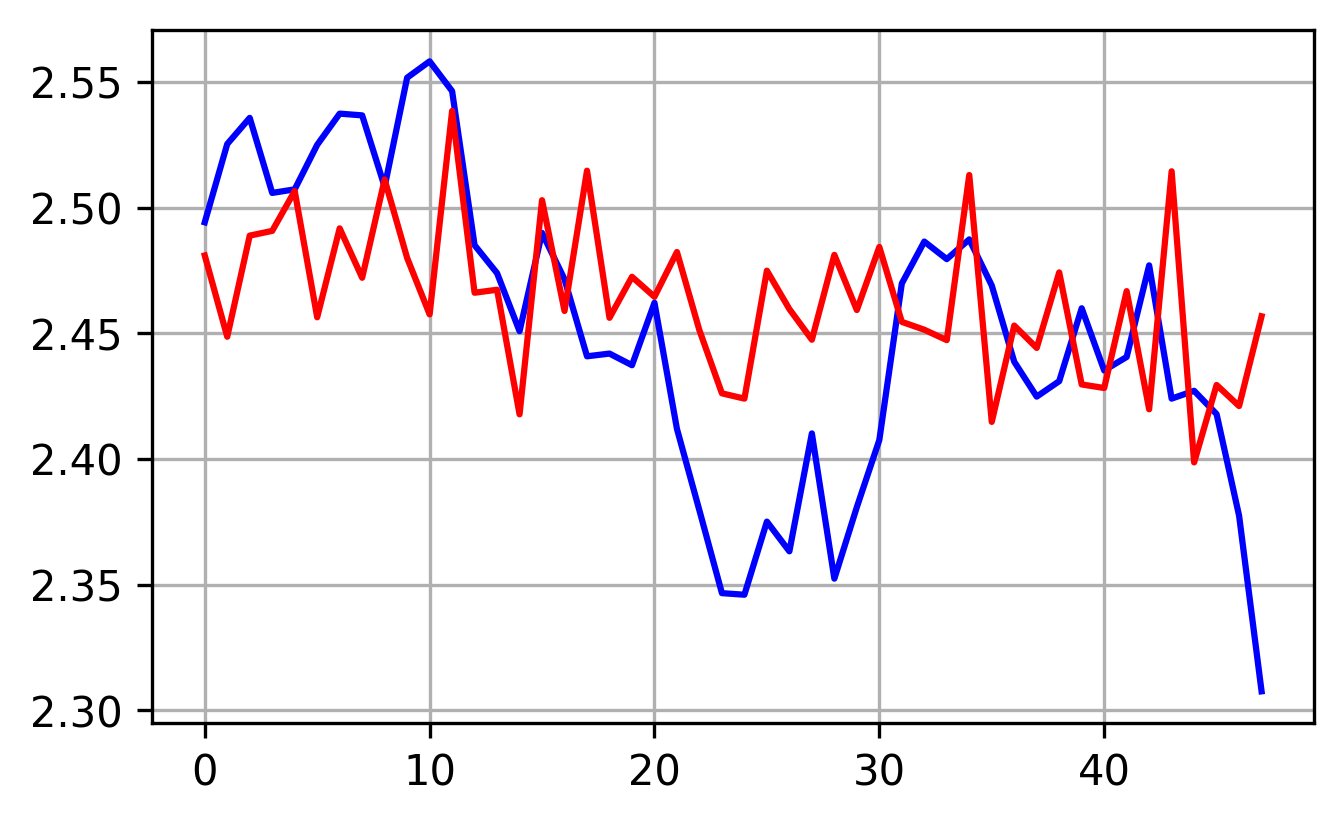

In [781]:
i_48 = 587
from matplotlib.pyplot import MultipleLocator
plt.figure(figsize=(5,3),dpi=300)
x_major_locator = MultipleLocator(10)
plt.gca().xaxis.set_major_locator(x_major_locator)
net.load_state_dict(torch.load('./model/Adam_Stock/'+stock+'_net_fractional_plus_1_0_'+str(pre_days)+'.pth'))
out = net(X_test)
plt.plot(y_test.cpu().detach().numpy()[i_48],c='b')
plt.plot(out.cpu().detach().numpy()[i_48],c='r')
plt.grid()
MAPE(y_test.cpu().detach().numpy()[i_48],out.cpu().detach().numpy()[i_48])

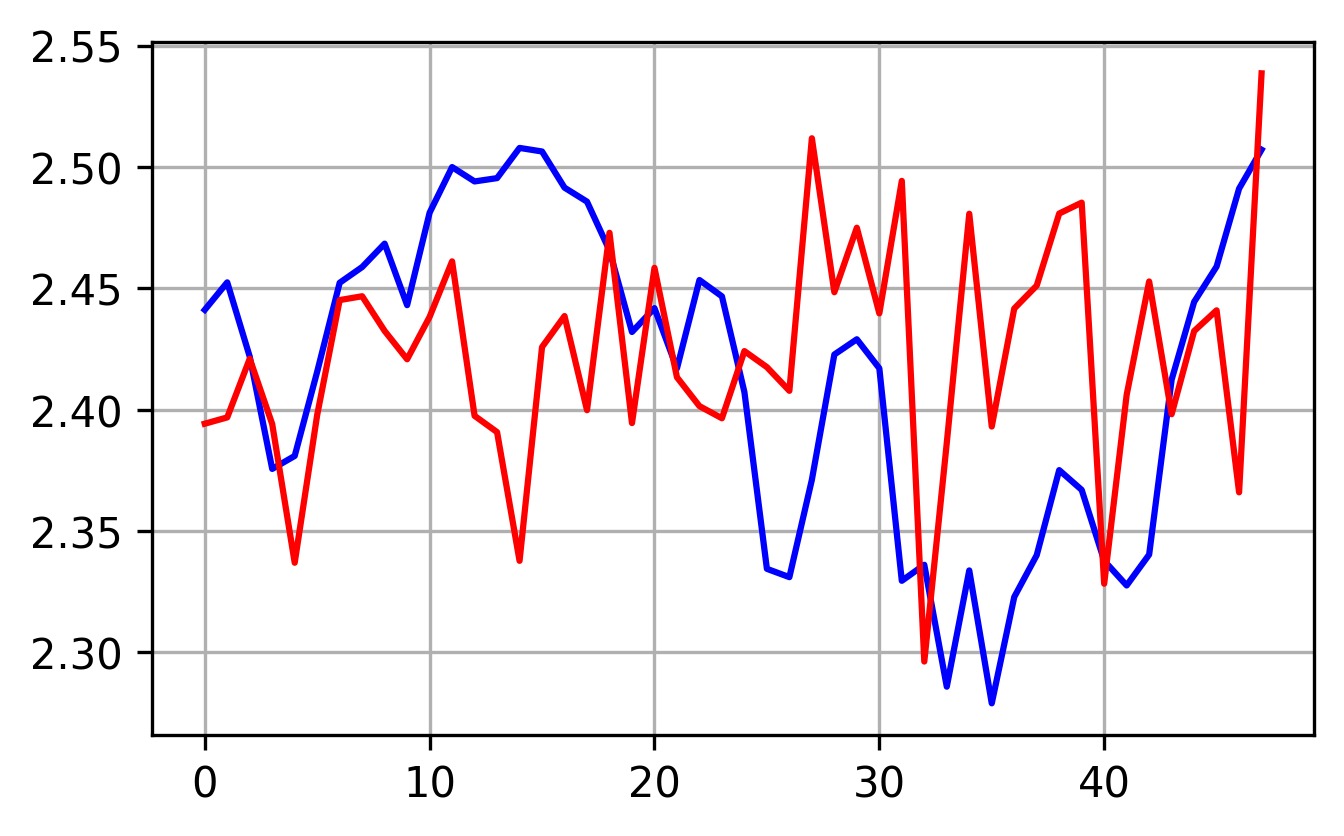

In [783]:
i_48 = 105
from matplotlib.pyplot import MultipleLocator
plt.figure(figsize=(5,3),dpi=300)
x_major_locator = MultipleLocator(10)
plt.gca().xaxis.set_major_locator(x_major_locator)
net.load_state_dict(torch.load('./model/Adam_Stock/'+stock+'_net_fractional_plus_0_9_'+str(pre_days)+'.pth'))
out = net(X_test)
plt.plot(y_test.cpu().detach().numpy()[i_48],c='b')
plt.plot(out.cpu().detach().numpy()[i_48],c='r')
plt.grid()

In [746]:
#GSPC，DJI，IXIC，FTSE，GDAXI，N225 data preprocessing
slide_windows_size = 36  #i.e.,input length
pre_days = 48     #i.e.,prediction lengths,48,96,192,384
#stock = 'GSPC'   #GSPC，DJI，IXIC，FTSE，GDAXI，N225 
stock = 'ETTh1'  #ETTh1，ETTh2，ETTm1，ETTm2
df_DJIA = pd.read_csv(r'./data/'+stock+'.csv')
#del df_DJIA['Date']
del df_DJIA['date']        #ETT
sca_DJIA = scaler.fit_transform(df_DJIA)
#label = t.tensor([row[4] for row in sca_DJIA][slide_windows_size:]).view(-1,1)  #stock
label = t.tensor([row[6] for row in sca_DJIA][slide_windows_size:]).view(-1,1)  #ETT
sca_DJIA = t.tensor(sca_DJIA[:-pre_days])
#label
deq_DJIA = deque(maxlen=pre_days)
DJIA_label = []
for i in label:
    deq_DJIA.append(list(i))
    if len(deq_DJIA)==pre_days:
        DJIA_label.append(list(deq_DJIA))
DJIA_label = t.Tensor(DJIA_label).view(-1,pre_days)
#X
deq_DJIA = deque(maxlen=slide_windows_size)
DJIA_X = []
for i in sca_DJIA:
    deq_DJIA.append(list(i))
    if len(deq_DJIA)==slide_windows_size:
        DJIA_X.append(list(deq_DJIA))
DJIA_X = t.Tensor(DJIA_X)


X_DJIA, y_DJIA = DJIA_X.to(device), DJIA_label.to(device)

X_train,X_val,X_test,y_train,y_val,y_test = split(X_DJIA,y_DJIA)   #7:2:1


class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        #self.linear1 = Linear(slide_windows_size*5,128)
        self.linear1 = Linear(slide_windows_size*7,128)  #ETT
        self.linear2 = Linear(128,64)
        self.linear3 = Linear(64,32)
        self.linear4 = Linear(32,pre_days)
        self.w1,self.b1 = self.linear1.weight,self.linear1.bias
        self.w2,self.b2 = self.linear2.weight,self.linear2.bias
        self.w3,self.b3 = self.linear3.weight,self.linear3.bias
        self.w4,self.b4 = self.linear4.weight,self.linear4.bias
    
    def forward(self,x):
        #x = x.view(-1,slide_windows_size*5)
        x = x.view(-1,slide_windows_size*7)   #ETT
        y2 = Linear_fractional.apply(x,self.w1,self.b1)   
        y3 = Linear_fractional.apply(y2,self.w2,self.b2)   
        y4 = Linear_fractional.apply(y3,self.w3,self.b3) 
        y5 = Linear_fractional.apply(y4,self.w4,self.b4)  
        return y5
    
net = Net()
#torch.save(net.state_dict(), r'./model/'+stock+'_'+str(pre_days)+'_net.pth')

In [748]:
net = Net()
net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_plus_0_9_'+str(pre_days)+'.pth'))  
net.to(device)
out = net(X_test)  
MSE_f_09 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_09 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_09 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_plus_1_0_'+str(pre_days)+'.pth'))
out = net(X_test) 
MSE_f_10 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_10 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_10 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_plus_1_1_'+str(pre_days)+'.pth'))
out = net(X_test)
MSE_f_11 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_11 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_11 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_plus_1_2_'+str(pre_days)+'.pth'))
out = net(X_test)
MSE_f_12 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_12 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_12 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_plus_1_3_'+str(pre_days)+'.pth'))
out = net(X_test)
MSE_f_13 = round(MSE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAE_f_13 = round(MAE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)
MAPE_f_13 = round(MAPE(y_test.cpu().detach().numpy(),out.cpu().detach().numpy()),3)

print('MSE:')
print('MSE_09:',MSE_f_09)
print('MSE_10:',MSE_f_10)
print('MSE_11:',MSE_f_11)
print('MSE_12:',MSE_f_12)
print('MSE_13:',MSE_f_13)

print('MAE:')
print('MAE_09:',MAE_f_09)
print('MAE_10:',MAE_f_10)
print('MAE_11:',MAE_f_11)
print('MAE_12:',MAE_f_12)
print('MAE_13:',MAE_f_13)

print('MAPE:')
print('MAPE_09:',MAPE_f_09)
print('MAPE_10:',MAPE_f_10)
print('MAPE_11:',MAPE_f_11)
print('MAPE_12:',MAPE_f_12)
print('MAPE_13:',MAPE_f_13)

MSE:
MSE_09: 0.092
MSE_10: 0.06
MSE_11: 0.084
MSE_12: 0.073
MSE_13: 0.087
MAE:
MAE_09: 0.236
MAE_10: 0.183
MAE_11: 0.229
MAE_12: 0.213
MAE_13: 0.237
MAPE:
MAPE_09: 7.0
MAPE_10: 2.259
MAPE_11: 2.062
MAPE_12: 1.859
MAPE_13: 1.318


In [757]:
net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_plus_1_3_'+str(pre_days)+'.pth'))
out = net(X_test)
MAPE_fiii_best = 10
length = len(y_test.cpu().detach().numpy())
print(length)
for iii in range(0,length):
    MAPE_fiii = MSE(y_test.cpu().detach().numpy()[iii],out.cpu().detach().numpy()[iii])
    if MAPE_fiii<MAPE_fiii_best:
        MAPE_fiii_best = MAPE_fiii
        print('最优MAPE:'+str(MAPE_fiii_best))
        print('最优i:'+str(iii))

1733
最优MAPE:0.04814574
最优i:0
最优MAPE:0.03425977
最优i:1
最优MAPE:0.028710738
最优i:40
最优MAPE:0.024614627
最优i:44
最优MAPE:0.01874339
最优i:46
最优MAPE:0.01238925
最优i:48
最优MAPE:0.0113325855
最优i:863
最优MAPE:0.008579529
最优i:866
最优MAPE:0.008297999
最优i:962
最优MAPE:0.00824707
最优i:1091
最优MAPE:0.0078542195
最优i:1094
最优MAPE:0.0067380588
最优i:1114
最优MAPE:0.0066605317
最优i:1115
最优MAPE:0.0059074243
最优i:1128
最优MAPE:0.005117391
最优i:1298


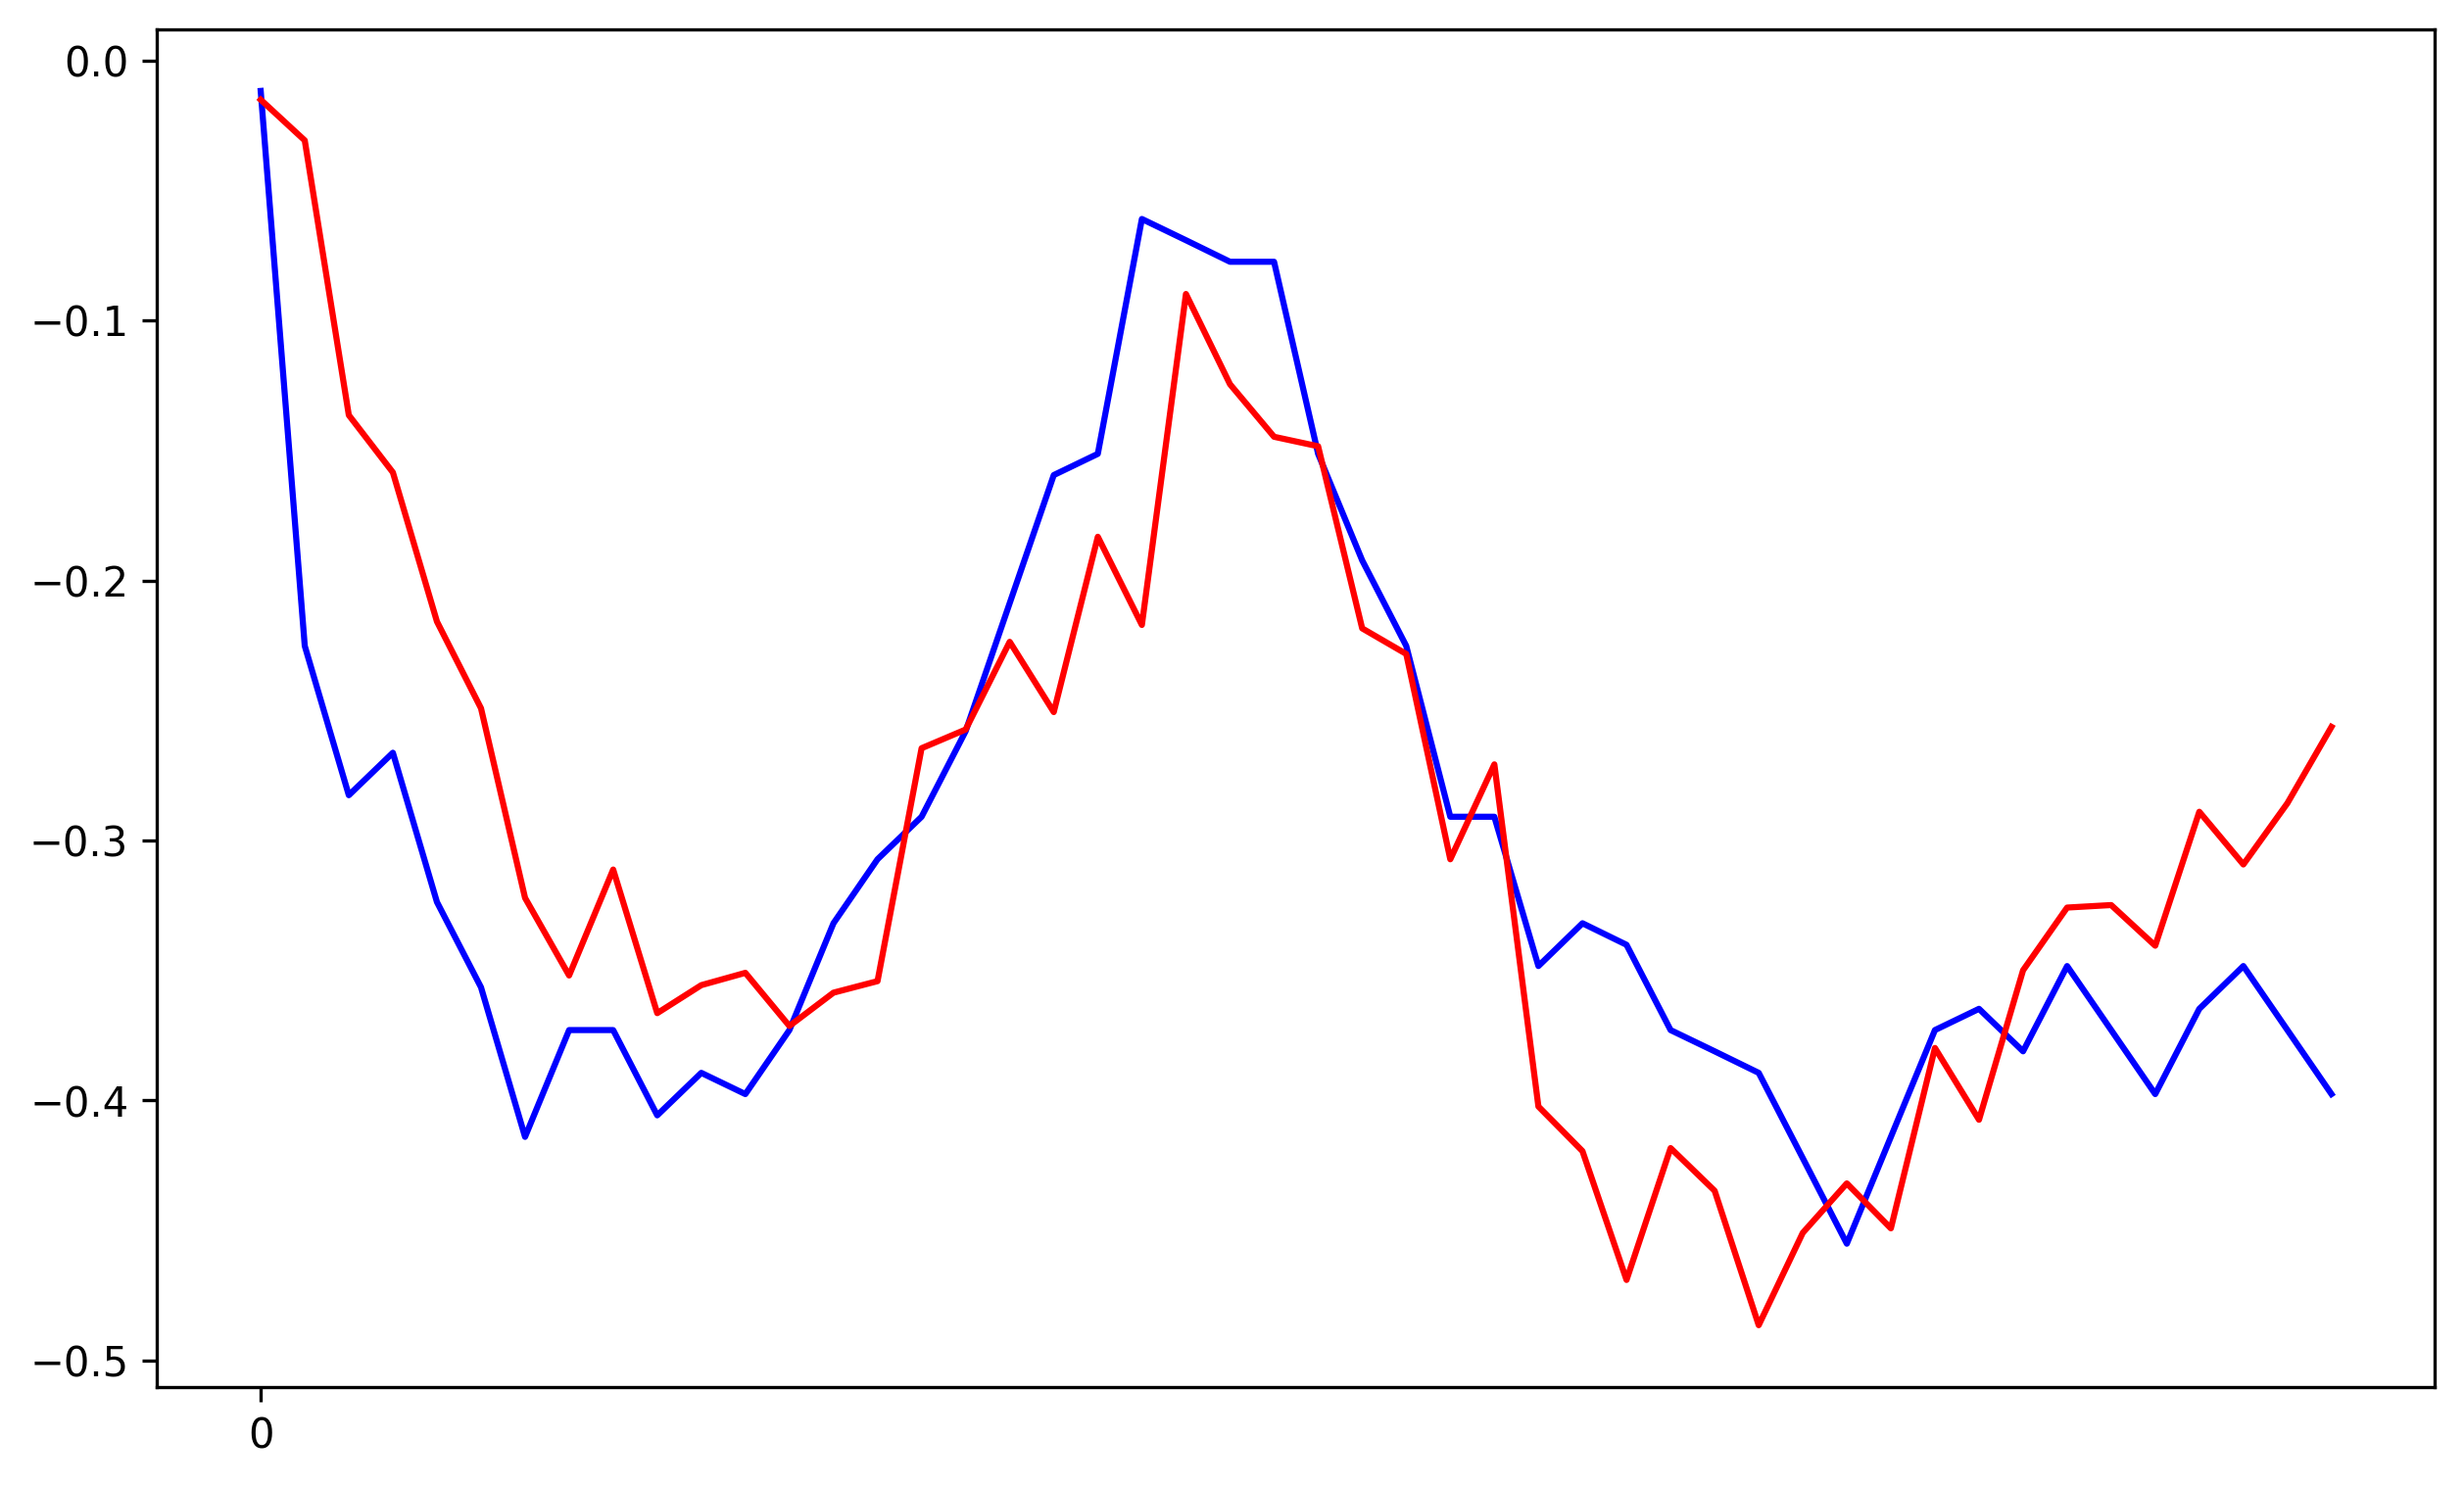

In [759]:
net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_plus_1_3_'+str(pre_days)+'.pth'))
out = net(X_test)
plt.figure(figsize=(10,6),dpi=300)
x_major_locator = MultipleLocator(50)
plt.gca().xaxis.set_major_locator(x_major_locator)
s_i = 1298
plt.plot(y_test.cpu().detach().numpy()[s_i],c='b')
plt.plot(out.cpu().detach().numpy()[s_i],c='r')

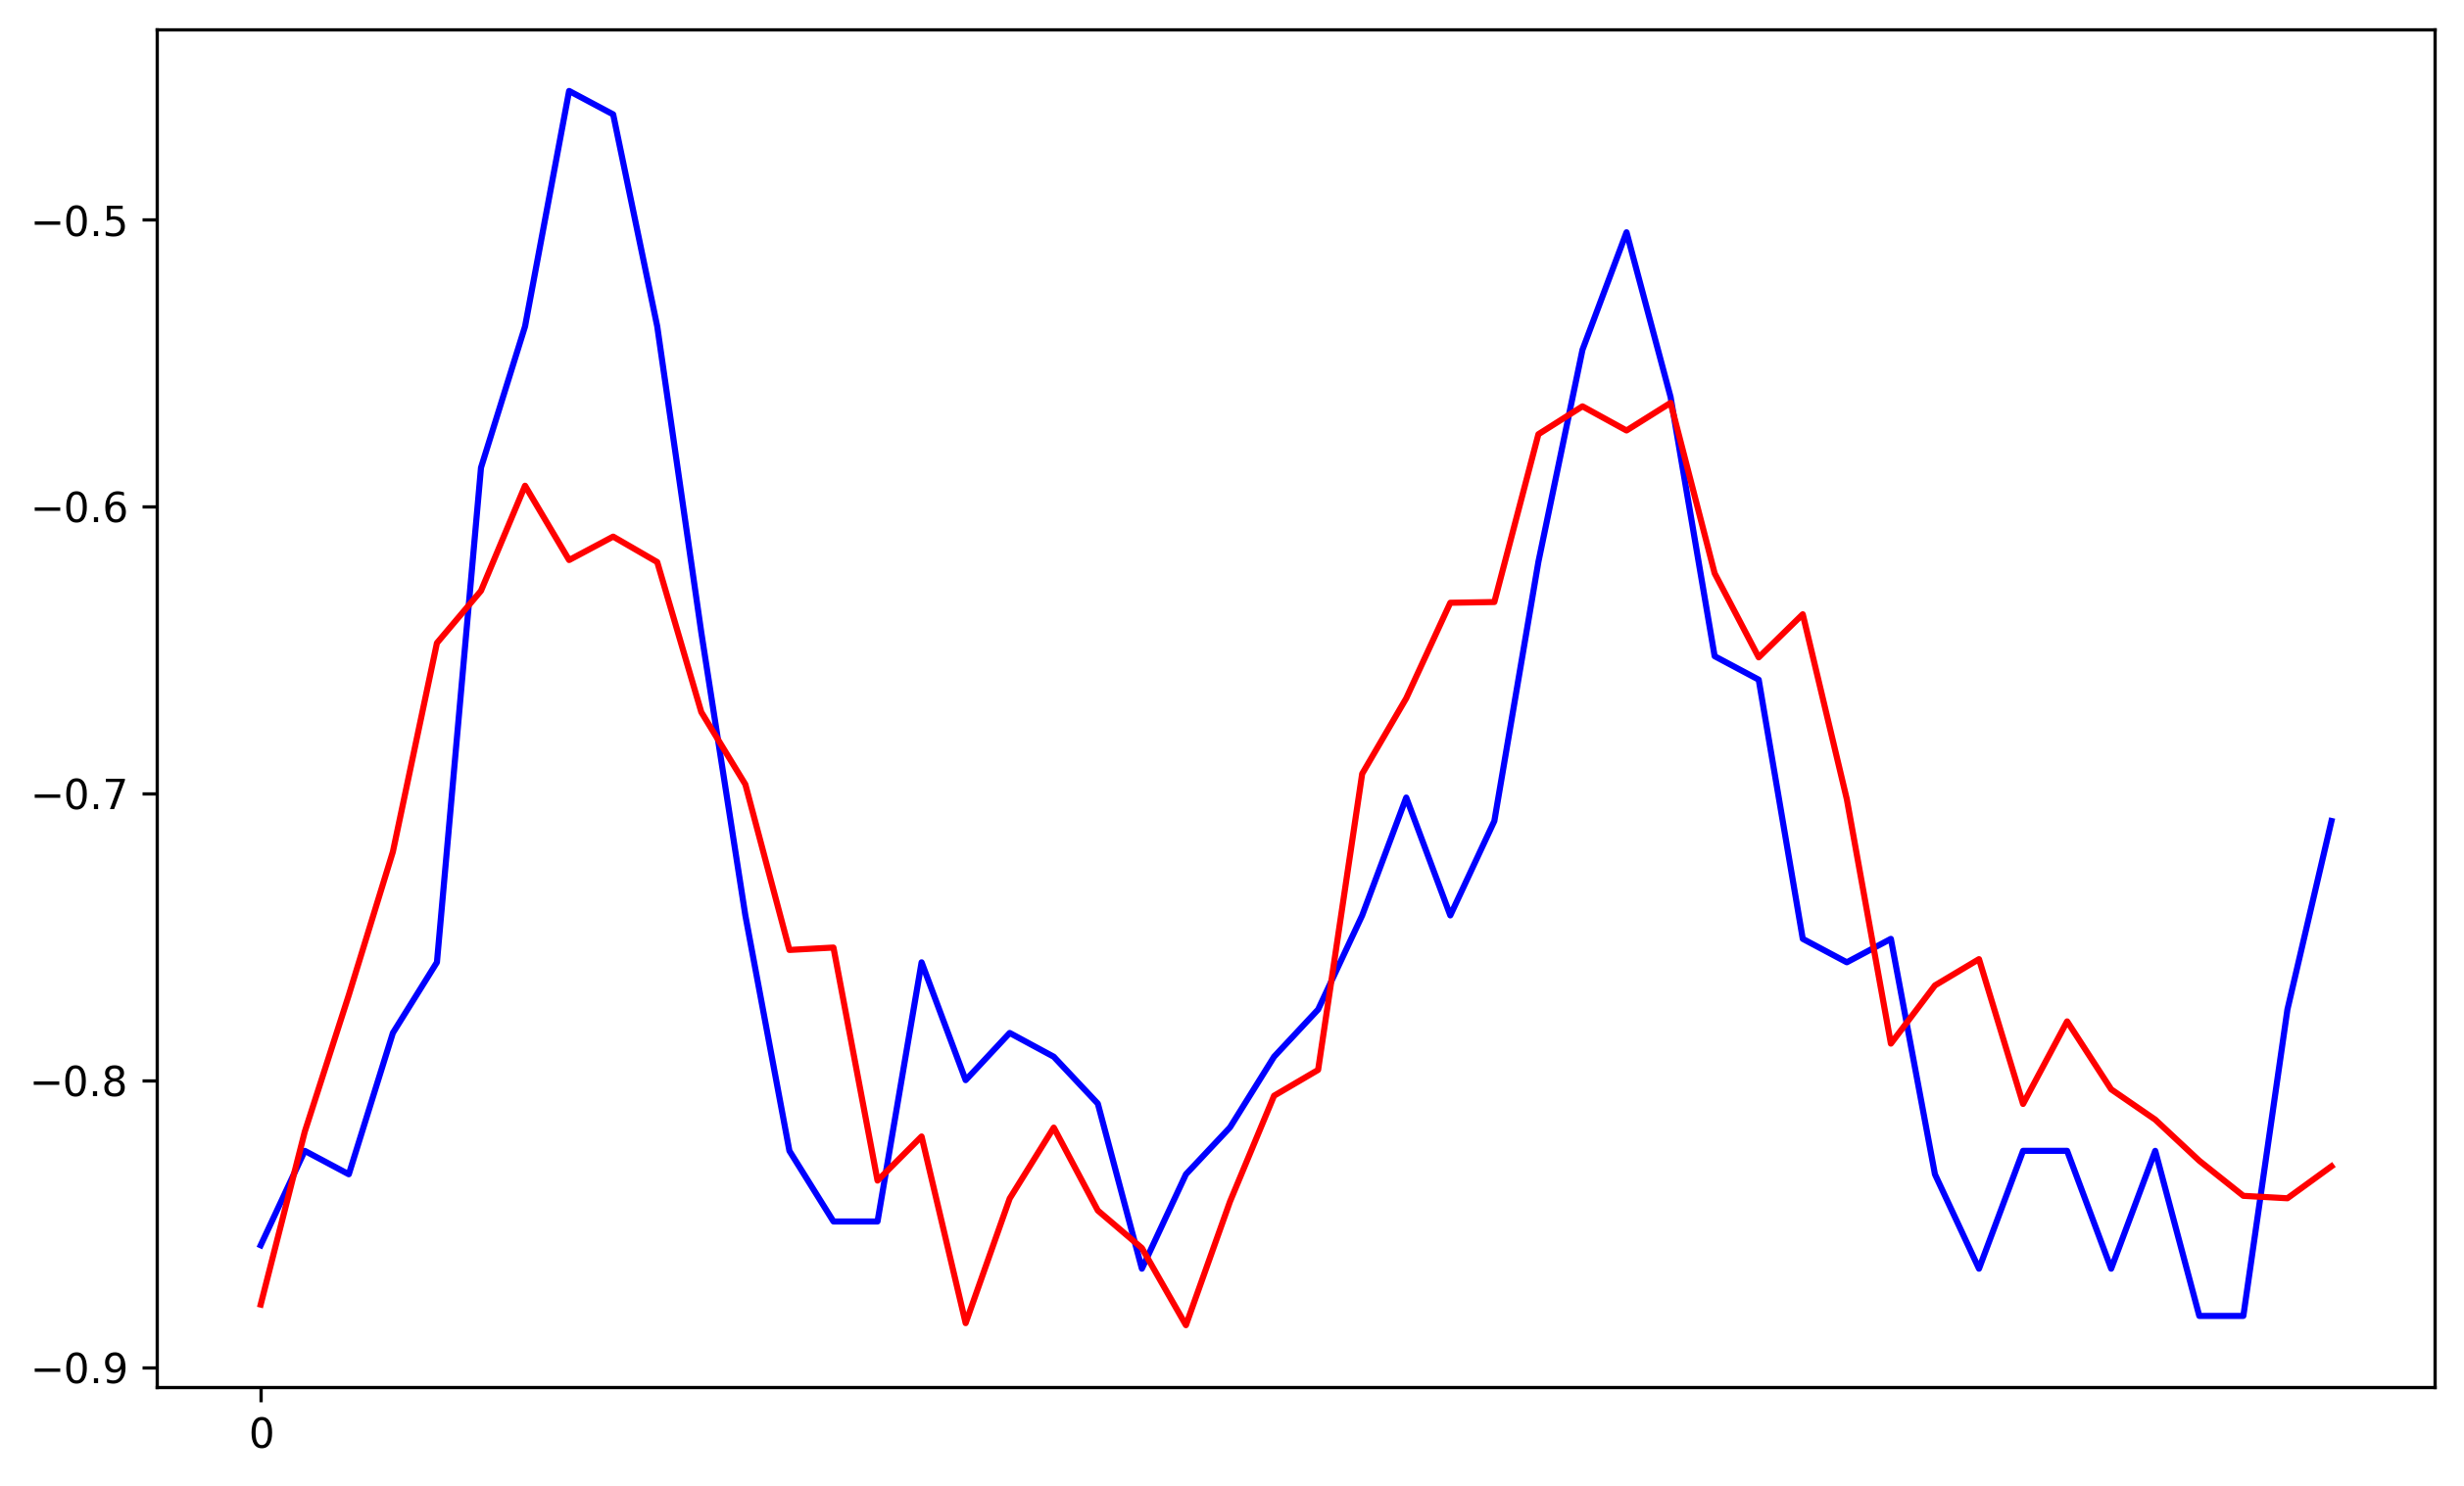

In [745]:
net.load_state_dict(torch.load('./model/Adam_ETT/'+stock+'_net_fractional_1_0_'+str(pre_days)+'.pth'))
out = net(X_test)
plt.figure(figsize=(10,6),dpi=300)
x_major_locator = MultipleLocator(50)
plt.gca().xaxis.set_major_locator(x_major_locator)
plt.plot(y_test.cpu().detach().numpy()[s_i],c='b')
plt.plot(out.cpu().detach().numpy()[s_i],c='r')

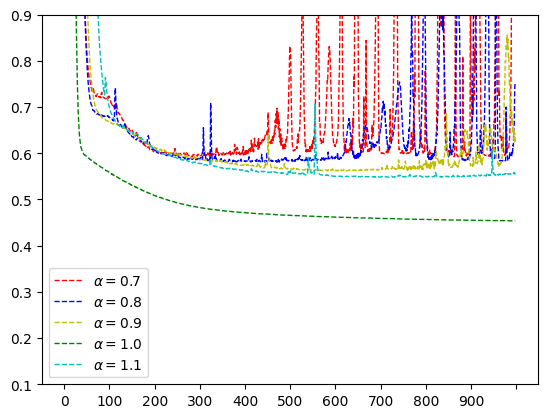

In [172]:
from matplotlib.pyplot import MultipleLocator
x_major_locator = MultipleLocator(100)
vfosgd_pf_loss = pd.read_csv(r'./train_loss_data/Stock/N225_net_fractional_plus_96.csv')
#vfosgd_pf_loss = pd.read_csv(r'./train_loss_data/ETT/ETTh1_net_fractional_plus_384.csv')
plt.plot(vfosgd_pf_loss.iloc[0,1:1000],'r--',label=r'$\alpha=0.7$',markersize='1',linewidth ='1')
plt.plot(vfosgd_pf_loss.iloc[1,1:1000],'b--',label=r'$\alpha=0.8$',markersize='1',linewidth ='1')
plt.plot(vfosgd_pf_loss.iloc[2,1:1000],'y--',label=r'$\alpha=0.9$',markersize='1',linewidth ='1')
plt.plot(vfosgd_pf_loss.iloc[3,1:1000],'g--',label=r'$\alpha=1.0$',markersize='1',linewidth ='1')
plt.plot(vfosgd_pf_loss.iloc[4,1:1000],'c--',label=r'$\alpha=1.1$',markersize='1',linewidth ='1')
plt.gca().xaxis.set_major_locator(x_major_locator)
plt.ylim(0.1,0.9)
#plt.ylim(0.8,2)
plt.legend()

In [205]:
y_test.shape

torch.Size([589, 48])